Note that in the code above, we assumed that the resume dataset is stored in a CSV file named resumes.csv, with the following columns: resume, category, and job_description. You may need to modify the code to match the structure of your dataset.

In [11]:
# run this cell if a dependency not found or an error message appear
!pip install tensorflow
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-hub


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import plot_model
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
import re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [33]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
model = hub.load(module_url)

In [34]:
# Read datasets
data = pd.read_csv('FWV_dataset.csv', sep=';')
validationData = pd.read_csv('RJP_evaluation.csv', sep=';')

In [35]:
# Preprocessing function
def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove non-word characters
    text = re.sub(r'\W+', ' ', text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z., ]+', '', text)
    return text

data['jobPost'] = data['jobPost'].apply(preprocess)

# Apply preprocessing to the "resume" column
validationData['jobPost'] = validationData['jobPost'].apply(preprocess)

In [36]:
categories = np.array(data['title'])
jobPosts = np.array(data['jobPost'])

validationCategories = np.array(validationData['title'])
validationJobPosts = np.array(validationData['jobPost'])

In [37]:
gpt_labels =data['title'].unique()
validation_labels = validationData['title'].unique()
print(gpt_labels)
print(validation_labels)

['Civil Engineer' 'Cooks' 'Customer support - Sales' 'Financial services'
 'Human resources' 'Landscaping - workers' 'Lawyer' 'Logistics'
 'Marketing' 'Retail services' 'Teachers' 'Technicians' 'Doctor' 'Nurse'
 'Pharmacist' 'Spa Therapist' 'Application Developer' 'Barman'
 'Chambermaid' 'Hotel Manager' 'Receptionist' 'Trainee-junior lawyer'
 'Lifeguard' 'Restaurant Manager' 'Systems Engineer' 'Web developer'
 'Software Architect' 'Frontend developer']
['Web developer' 'Technicians' 'Teachers' 'Systems Engineer'
 'Spa Therapist' 'Software Architect' 'Retail services' 'Pharmacist'
 'Nurse' 'Marketing' 'Logistics' 'Landscaping - workers' 'Human resources'
 'Frontend developer' 'Financial services' 'Doctor'
 'Customer support - Sales' 'Cook' 'Civil Engineer'
 'Application Developer' 'Barman' 'Chambermaid' 'Hotel Manager'
 'Lifeguard' 'Receptionist' 'Restaurant Manager' 'Lawyer'
 'Trainee-junior lawyer']


In [38]:
# Convert categories to integer labels
le = LabelEncoder()
y = le.fit_transform(categories)
yValLabels = le.fit_transform(validationCategories)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(jobPosts, y, test_size=0.2, random_state=42)
X_trainValidation, X_testValidation, y_trainValidation, y_testValidation = train_test_split(validationJobPosts, yValLabels, test_size=0.95, random_state=42)

print(jobPosts.shape, validationJobPosts.shape)

(5104,) (2854,)


In [39]:
# Generate sentence embeddings for train and test sets
X_train_embeddings = np.array(model(X_train))
X_test_embeddings = np.array(model(X_test))

X_train_embeddingsVal = np.array(model(X_trainValidation))
X_test_embeddingsVal = np.array(model(X_testValidation))


In [40]:
# Define model architecture

num_classes = len(np.unique(y_train))

input_layer = tf.keras.layers.Input(shape=(512,), dtype=tf.float32)
hidden_layer = tf.keras.layers.Dense(units=256, activation='relu')(input_layer)
output_layer = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adadelta(learning_rate=0.15, rho=0.95)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(X_train_embeddings, y_train, validation_data=(X_test_embeddings, y_test), epochs=37, batch_size=32)

Epoch 1/37
128/128 [==============================] - 1s 3ms/step - loss: 3.2365 - accuracy: 0.3924 - val_loss: 3.1269 - val_accuracy: 0.6386
Epoch 2/37
128/128 [==============================] - 0s 2ms/step - loss: 2.9752 - accuracy: 0.7465 - val_loss: 2.8141 - val_accuracy: 0.7747
Epoch 3/37
128/128 [==============================] - 0s 2ms/step - loss: 2.5932 - accuracy: 0.8107 - val_loss: 2.3828 - val_accuracy: 0.8394
Epoch 4/37
128/128 [==============================] - 0s 3ms/step - loss: 2.1174 - accuracy: 0.8651 - val_loss: 1.8982 - val_accuracy: 0.8609
Epoch 5/37
128/128 [==============================] - 0s 2ms/step - loss: 1.6413 - accuracy: 0.8895 - val_loss: 1.4588 - val_accuracy: 0.8981
Epoch 6/37
128/128 [==============================] - 0s 2ms/step - loss: 1.2456 - accuracy: 0.9241 - val_loss: 1.1167 - val_accuracy: 0.9305
Epoch 7/37
128/128 [==============================] - 0s 2ms/step - loss: 0.9505 - accuracy: 0.9420 - val_loss: 0.8671 - val_accuracy: 0.9442
Epoch 

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
32/32 [==============================] - 0s 772us/step
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        37
           1       1.00      0.97      0.98        33
           2       1.00      1.00      1.00        42
           3       0.91      1.00      0.95        41
           4       1.00      1.00      1.00        42
           5       0.98      1.00      0.99        59
           6       1.00      1.00      1.00        34
           7       1.00      1.00      1.00        53
           8       1.00      0.95      0.97        37
           9       1.00      1.00      1.00        26
          10       1.00      1.00      1.00        24
          11       1.00      1.00      1.00        39
          12       1.00      0.97      0.98        29
          13       1.00      1.00      

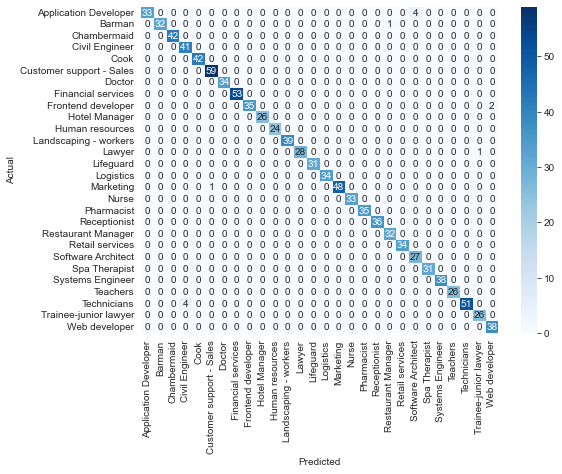

                          precision    recall  f1-score   support

   Application Developer       1.00      0.89      0.94        37
                  Barman       1.00      0.97      0.98        33
             Chambermaid       1.00      1.00      1.00        42
          Civil Engineer       0.91      1.00      0.95        41
                    Cook       1.00      1.00      1.00        42
Customer support - Sales       0.98      1.00      0.99        59
                  Doctor       1.00      1.00      1.00        34
      Financial services       1.00      1.00      1.00        53
      Frontend developer       1.00      0.95      0.97        37
           Hotel Manager       1.00      1.00      1.00        26
         Human resources       1.00      1.00      1.00        24
   Landscaping - workers       1.00      1.00      1.00        39
                  Lawyer       1.00      0.97      0.98        29
               Lifeguard       1.00      1.00      1.00        31
         

In [41]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, show_layer_activations=True, show_trainable=True)
# Make predictions on test set
y_pred = model.predict(X_test_embeddings)
y_pred = np.argmax(y_pred, axis=1)

# Print classification report and confusion matrix
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_), annot_kws={'fontsize':10})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
plt.show()

# confusion matrix to excel
df_conf_matrix = pd.DataFrame(conf_matrix, le.classes_, le.classes_)
df_conf_matrix.to_excel('confusion_matrix_test_set.xlsx')

# Compute evaluation metrics
class_labels = list(le.classes_)
report = classification_report(y_test, y_pred, target_names=class_labels)

# Print evaluation metrics
print(report)

85/85 [==============================] - 0s 804us/step


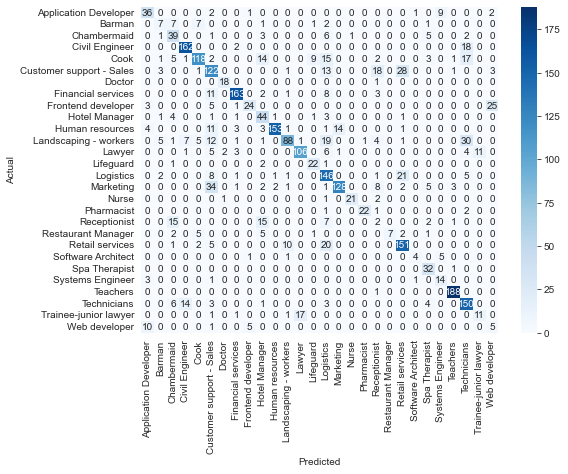

                          precision    recall  f1-score   support

   Application Developer       0.64      0.71      0.67        51
                  Barman       0.35      0.27      0.30        26
             Chambermaid       0.48      0.67      0.56        58
          Civil Engineer       0.88      0.89      0.88       182
                    Cook       0.86      0.63      0.72       188
Customer support - Sales       0.54      0.64      0.59       190
                  Doctor       0.86      0.95      0.90        19
      Financial services       0.92      0.87      0.89       188
      Frontend developer       0.77      0.41      0.54        58
           Hotel Manager       0.47      0.77      0.59        57
         Human resources       0.97      0.80      0.88       191
   Landscaping - workers       0.84      0.50      0.63       176
                  Lawyer       0.85      0.76      0.81       139
               Lifeguard       0.65      0.85      0.73        26
         

In [42]:
# Make predictions on test set
y_predVal = model.predict(X_test_embeddingsVal)
y_predVal = np.argmax(y_predVal, axis=1)

# Compute evaluation metrics
class_labels = list(le.classes_)
report = classification_report(y_testValidation, y_predVal, target_names=class_labels)
matrix = confusion_matrix(y_testValidation, y_predVal, labels=range(len(class_labels)))

# Create confusion matrix for validation dataset
conf_matrix = confusion_matrix(y_testValidation, y_predVal)

# Create heatmap of confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=list(le.classes_), yticklabels=list(le.classes_), annot_kws={'fontsize':10})
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
#ax.set_title('Confusion Matrix')
plt.show()

# confusion matrix to excel
df_conf_matrix = pd.DataFrame(conf_matrix, le.classes_, le.classes_)
df_conf_matrix.to_excel('confusion_matrix_validation_set.xlsx')

# Print evaluation metrics
print(report)